# Table of Contents

1. Word Embeddings
2. Attention Translation Models

## Install Libraires

In [1]:
# install gensim libraries
!pip install gensim
!pip install google-compute-engine

# afterwards, you need to reinstall python-boto package because of circular installation with google-compute-engine
# sudo apt-get remove python-boto
# sudo apt-get install python-boto

# install the open source neural machine translation system library
!pip install git+git://github.com/OpenNMT/OpenNMT-tf.git

  Cloning git://github.com/OpenNMT/OpenNMT-tf.git to /tmp/pip-req-build-j94hs346
  Running setup.py bdist_wheel for OpenNMT-tf ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-dy7110e5/wheels/c0/74/f3/b2379bea6d211593c2e27066e5616e34e37dc180df34f838cb
Successfully built OpenNMT-tf
  Found existing installation: OpenNMT-tf 1.14.0
    Uninstalling OpenNMT-tf-1.14.0:
      Successfully uninstalled OpenNMT-tf-1.14.0


In [2]:
# general libraries
import datetime 
import numpy as np 
import pandas as pd
import re
import tensorflow as tf

from importlib import reload
from nltk.corpus import stopwords

# our own library
import region

# model definition
from gensim.models import Word2Vec

# reduce feature sets
from sklearn.decomposition import PCA

# data visualization
from matplotlib import pyplot
%matplotlib inline

# opennmt
from opennmt import constants
from opennmt.utils.misc import count_lines

# enable eager execution
#tf.enable_eager_execution()

# define current time now to be used as saving the model
now = datetime.datetime.now()

In [3]:
# define the region
# also defined in tweets_processor.py but listed here for my own reference
region2idx = {
    "albuquerque":0,
    "billings":1,
    "calgary":2,
    "charlotte":3,
    "chicago":4,
    "cincinnati":5,
    "denver":6,
    "houston":7,
    "kansas city":8,
    "las vegas":9,
    "los angeles":10,
    "minneapolis":11,
    "montreal":12,
    "nashville":13,
    "new york":14,
    "oklahoma city":15,
    "phoenix":16,
    "pittsburgh":17,
    "san francisco":18,
    "seattle":19,
    "tampa":20,
    "toronto":21,
    "washington":22
}
idx2region = {
    0:"albuquerque",
    1:"billings",
    2:"calgary",
    3:"charlotte",
    4:"chicago",
    5:"cincinnati",
    6:"denver",
    7:"houston",
    8:"kansas city",
    9:"las vegas",
    10:"los angeles",
    11:"minneapolis",
    12:"montreal",
    13:"nashville",
    14:"new york",
    15:"oklahoma city",
    16:"phoenix",
    17:"pittsburgh",
    18:"san francisco",
    19:"seattle",
    20:"tampa",
    21:"toronto",
    22:"washington"
}

# Word Embedding

We started of with word embeddings because back-propagation is possible over continuous representations than discrete ones. 

Word embeddings overcome the many limitations that Bag of Words produced, in particular large sparse vectors that do not describe the meaning of the words. It provides a projection in the vector space where words with similar meanings cluster together. There are two main algorithms used for training the word vectors: Continuous Bag of Words (CBOW), which predicts the word given its context, and Skip-gram, which predicts the context given the word. We will employ the latter than the former because we have limited training data. Even though CBOW trains several times faster than Skip-gram and is slightly better in terms of accuracy for the frequency of words, it also requires a larger text corpus ranging from 1-100B words. Currently our training data is limited to 767,446 words.

GloVe is another successful word embedding algorithms with generally better word embeddings because it combines both the global statistics of matrix factorization techniques like LSA with the local context-based learning in Word2Vec. Since we would like the word embeddings to learn from live Twitter feeds used, we will stick with Word2Vec.

### Notes to self

The problem with word embedding is that you have to know the pair of words in advance.

Also, for classification tasks, fasttext performs faster than word2vec, might want to check this out later.

How to transfer learning and word embeddings:
1. Learn word embeddings from large text corpus (1-100B words)
2. Transfer embedding to a new task with smaller training set
3. Continue to finetune word embeddings with new data


### References

* https://www.youtube.com/watch?v=5PL0TmQhItY&t=583s
* using gensim: https://machinelearningmastery.com/what-are-word-embeddings/
* using tensorflow: https://medium.com/deep-math-machine-learning-ai/chapter-9-2-nlp-code-for-word2vec-neural-network-tensorflow-544db99f5334

In [4]:
# retrieve the datasets
df = pd.read_csv("/var/data/tweets_labelled.csv", sep=",")
df.head()

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,region
0,does anyone live in the Charleston area and wa...,3
1,You followed my friends to watch me😐,3
2,"Not a totally new subscriber, but just a few d...",20
3,no he doodoo,10
4,Wait that's not an Anime!!,13


In [14]:
df_40k = pd.read_csv("/var/data/tweets_labelled_40k.csv", sep=",")
df_40k.head()

,text,region
0,does anyone live in the Charleston area and wa...,3
1,You followed my friends to watch me😐,3
2,"Not a totally new subscriber, but just a few d...",13
3,no he doodoo,10
4,Wait that's not an Anime!!,13


## Word embeddings for the entire dataset

In [3]:
# convert each tweet to a list of words
sentences = list()
for sentence in df.text.tolist():
    word_list = re.sub("[^\w]", " ", sentence).split()
    sentences.append(word_list)
sentences[0:5]

[['does',
  'anyone',
  'live',
  'in',
  'the',
  'Charleston',
  'area',
  'and',
  'want',
  'a',
  'job',
  '10',
  'hr',
  'for',
  'Nov',
  '14',
  '21',
  'hmu'],
 ['You', 'followed', 'my', 'friends', 'to', 'watch', 'me'],
 ['Not',
  'a',
  'totally',
  'new',
  'subscriber',
  'but',
  'just',
  'a',
  'few',
  'days',
  'into',
  'it'],
 ['no', 'he', 'doodoo'],
 ['Wait', 'that', 's', 'not', 'an', 'Anime']]

In [4]:
# train the model 
model = Word2Vec(sentences, min_count=1)
model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))
print(model)

Word2Vec(vocab=767446, size=100, alpha=0.025)


In [ ]:
# load the model
# 40k: /var/data/word_embeddings_20181127_054247
# 2.5M: /var/data/word_embeddings_20181127_070749
"""
model = Word2Vec.load('/var/data/word_embeddings_20181127_070749')
"""

In [5]:
# list the words
words = list(model.wv.vocab)
words[0:5]

['does', 'anyone', 'live', 'in', 'the']

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


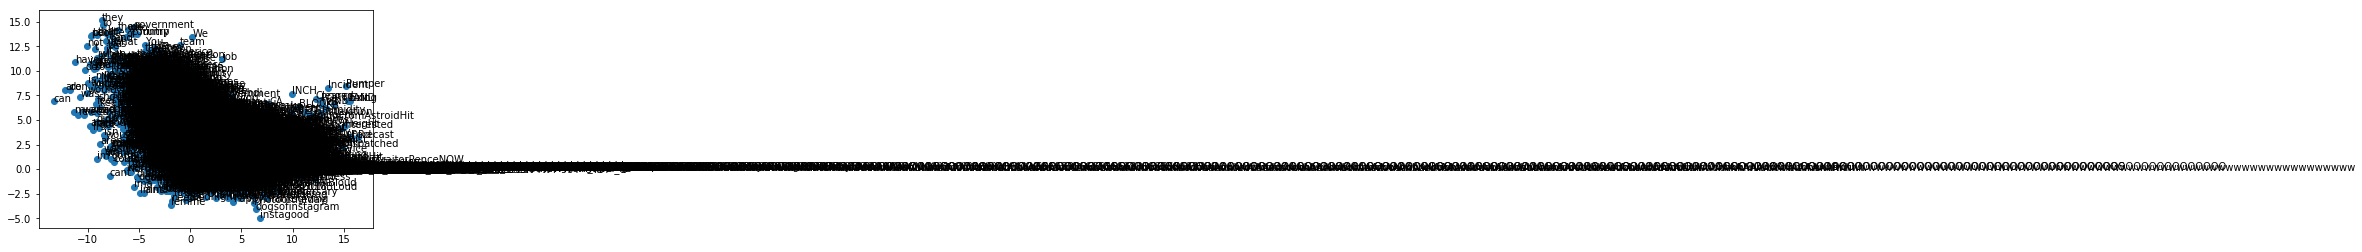

In [6]:
# retrieve all of the vectors from the trained model
x  = model[model.wv.vocab]

# fit a 2D PCA model to the vectors 
pca = PCA(n_components=2)
result = pca.fit_transform(x)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
pyplot.savefig('imgs/word2vec_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

# 2.5M: ~/w266-final/divya-models/word2vec_20181127_070749.png

In [26]:
# create a dictionary with frequency of words
unique_words = set(words)
unique_words_count = dict()
for word in unique_words:
    unique_words_count[word] = model.wv.vocab[word].count
unique_words_count = dict(sorted(unique_words_count.items(), key=lambda v: v[1], reverse=True))

In [33]:
# create a copy of that dictionary
unique_words_count_without_stopwords = unique_words_count.copy()

# filter out stopwords from the dictionary
stop_words = set(stopwords.words('english')) 
for key in unique_words_count.keys():
    if key.lower() in stop_words:
        unique_words_count_without_stopwords.pop(key, None)

In [34]:
# remove approximately 858 words
len(unique_words_count) - len(unique_words_count_without_stopwords)

858

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


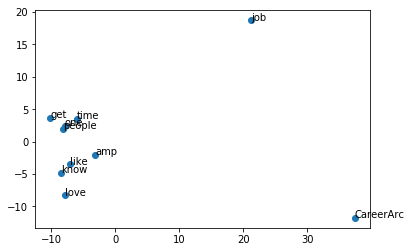

<Figure size 432x288 with 0 Axes>

In [47]:
# show the top 10 most frequent words 

# retrieve all of the vectors from the trained model
top10 = list(unique_words_count_without_stopwords)[:10]
top10_x  = model[top10]

# fit a 2D PCA model to the vectors 
pca = PCA(n_components=2)
result = pca.fit_transform(top10_x)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(top10):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
pyplot.savefig('imgs/word2vec_top10_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

## Word embeddings for each region

Redo the entire word embeddings done above into an encapsulated function

In [67]:
def plot_word_embeddings(data, region):
    
    # convert each tweet to a list of words
    sentences = list()
    for sentence in data:
        word_list = re.sub("[^\w]", " ", sentence).split()
        sentences.append(word_list)

    # train the model 
    model = Word2Vec(sentences, min_count=1)
    model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

    # list the words
    words = list(model.wv.vocab)
    
    # create a dictionary with frequency of words
    unique_words = set(words)
    unique_words_count = dict()
    for word in unique_words:
        unique_words_count[word] = model.wv.vocab[word].count
    unique_words_count = dict(sorted(unique_words_count.items(), key=lambda v: v[1], reverse=True))
    
    # create a copy of that dictionary
    unique_words_count_without_stopwords = unique_words_count.copy()

    # filter out stopwords from the dictionary
    stop_words = set(stopwords.words('english')) 
    for key in unique_words_count.keys():
        if key.lower() in stop_words:
            unique_words_count_without_stopwords.pop(key, None)

    # retrieve all of the vectors from the trained model
    top10 = list(unique_words_count_without_stopwords)[:10]
    top10_x  = model[top10]

    # fit a 2D PCA model to the vectors 
    pca = PCA(n_components=2)
    result = pca.fit_transform(top10_x)
    pyplot.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(top10):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
    pyplot.savefig('imgs/word2vec_top10_region{}_{}'.format(region, now.strftime('%Y%m%d_%H%M%S')))

Region 0: albuquerque


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


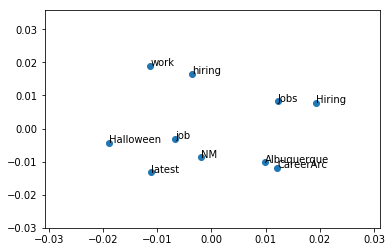

Region 1: billings


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


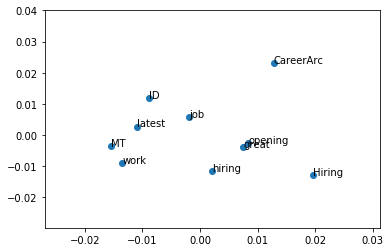

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Region 2: calgary


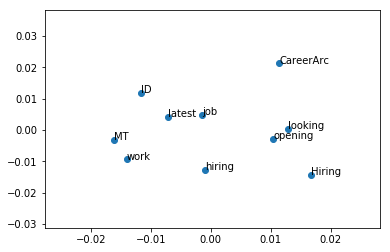

Region 3: charlotte


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


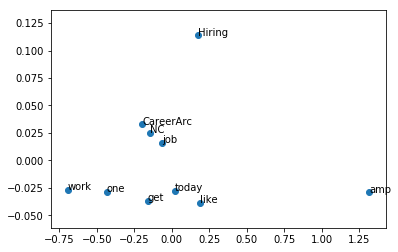

Region 4: chicago


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


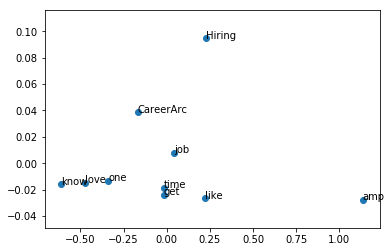

Region 5: cincinnati


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


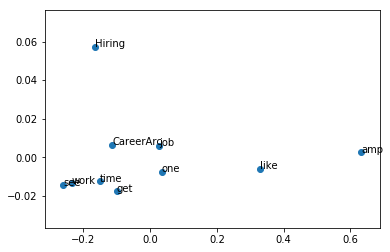

Region 6: denver


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


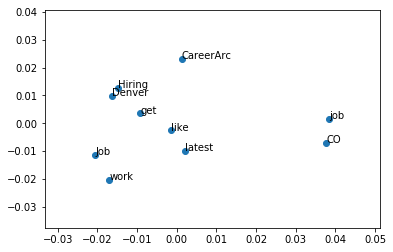

Region 7: houston


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


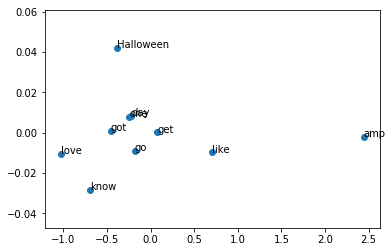

Region 8: kansas city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


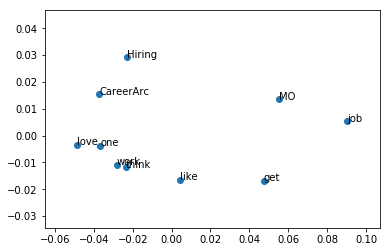

Region 9: las vegas


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


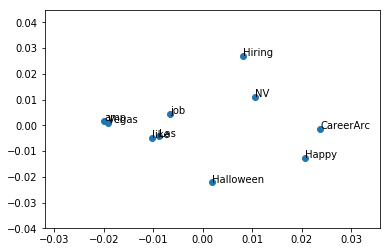

Region 10: los angeles


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


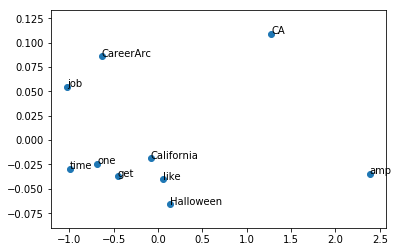

Region 11: minneapolis


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


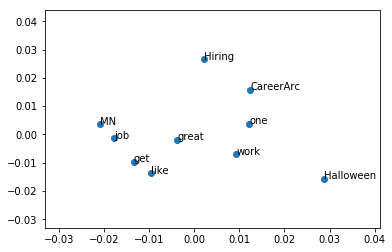

Region 12: montreal


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


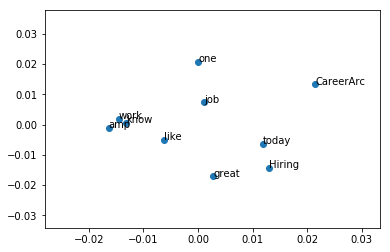

Region 13: nashville


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


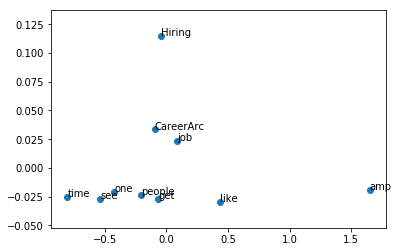

Region 14: new york


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


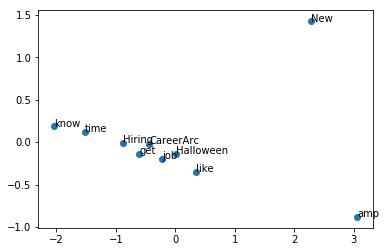

Region 15: oklahoma city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


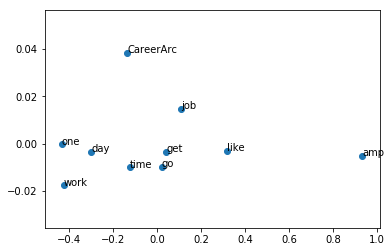

Region 16: phoenix


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


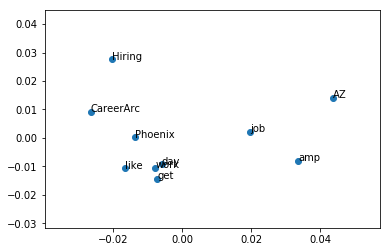

Region 17: pittsburgh


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


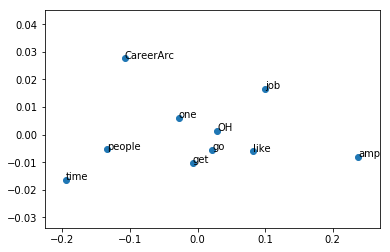

Region 18: san francisco


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


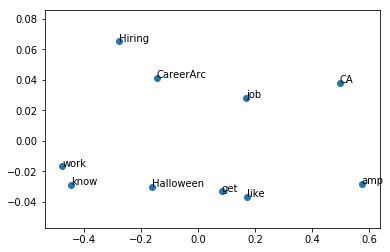

Region 19: seattle


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


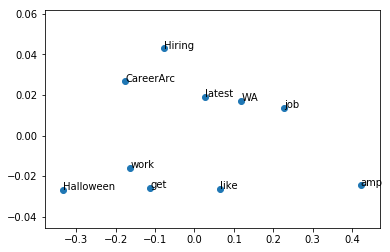

Region 20: tampa


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


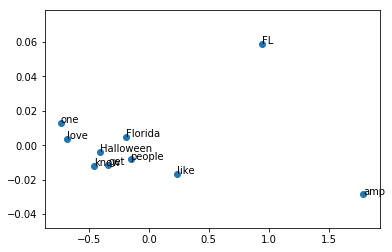

Region 21: toronto


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


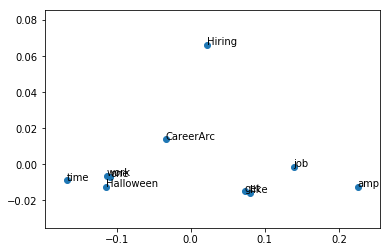

Region 22: washington


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


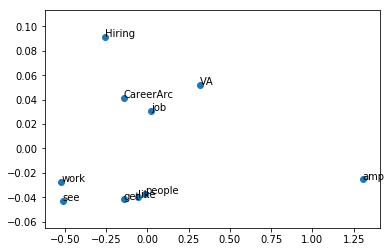

<Figure size 432x288 with 0 Axes>

In [69]:
# with 40K dataset
for region in regions_mapping.values():
    print('Region {}: {}'.format(region, idx2region[region]))
    data = df_40k.loc[df_40k.region == region]
    plot_word_embeddings(data.text.tolist(), region)

Region 0: albuquerque


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


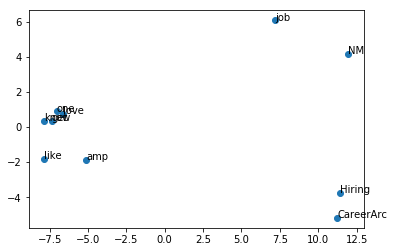

Region 1: billings


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


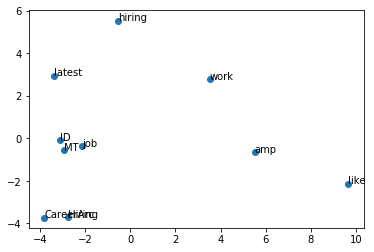

Region 2: calgary


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


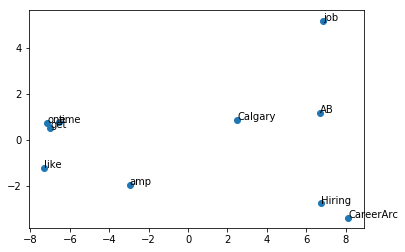

Region 3: charlotte


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


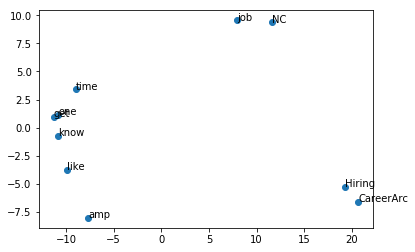

Region 4: chicago


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


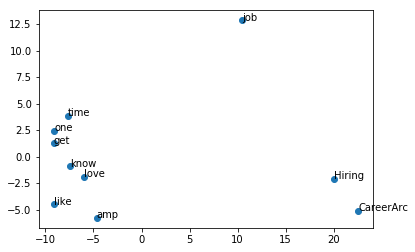

Region 5: cincinnati


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


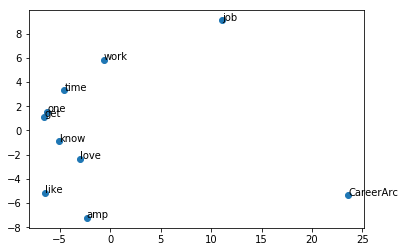

Region 6: denver


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


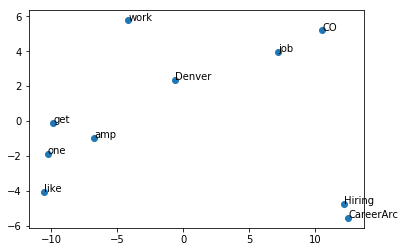

Region 7: houston


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


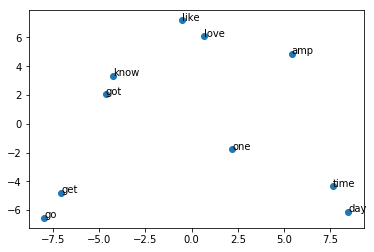

Region 8: kansas city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


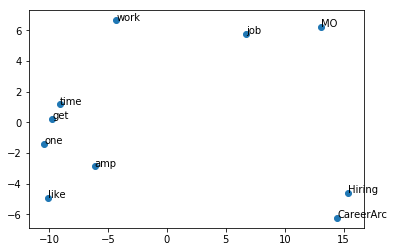

Region 9: las vegas


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


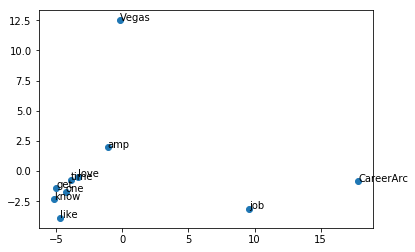

Region 10: los angeles


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


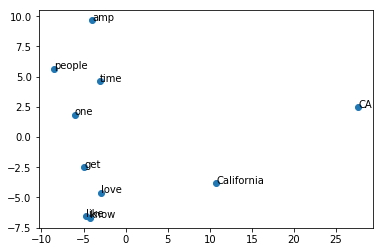

Region 11: minneapolis


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


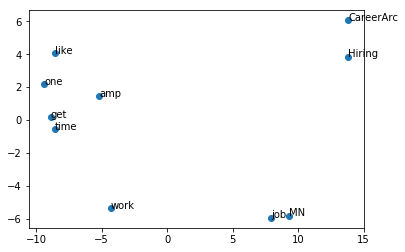

Region 12: montreal


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


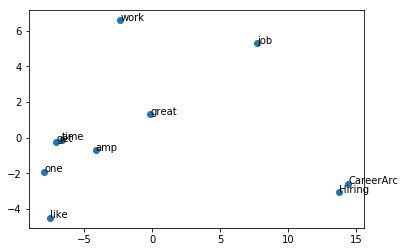

Region 13: nashville


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


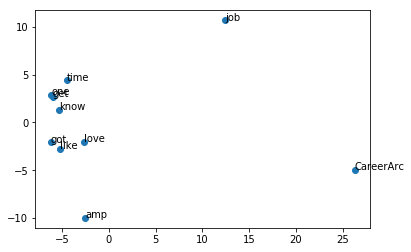

Region 14: new york


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


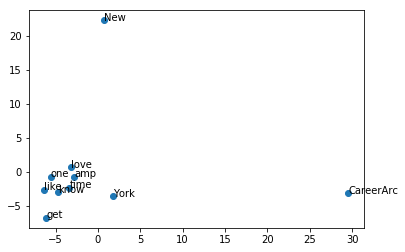

Region 15: oklahoma city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


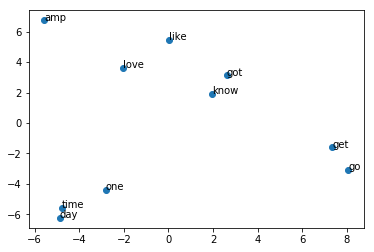

Region 16: phoenix


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


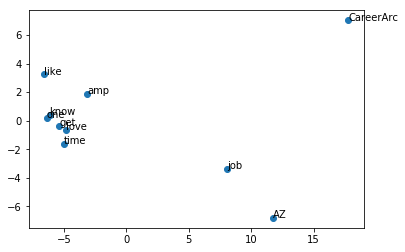

Region 17: pittsburgh


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


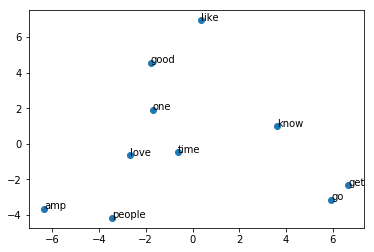

Region 18: san francisco


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


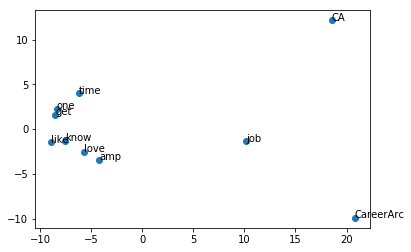

Region 19: seattle


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


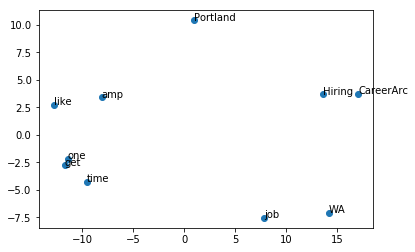

Region 20: tampa


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


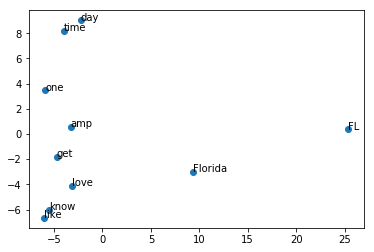

Region 21: toronto


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


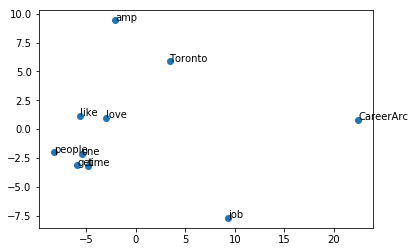

Region 22: washington


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


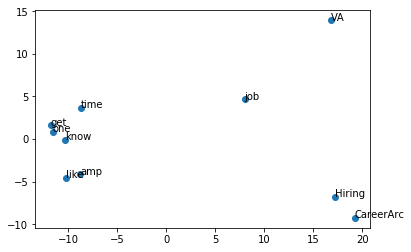

<Figure size 432x288 with 0 Axes>

In [70]:
# with 2.5M dataset
for region in regions_mapping.values():
    print('Region {}: {}'.format(region, idx2region[region]))
    data = df.loc[df.region == region]
    plot_word_embeddings(data.text.tolist(), region)

# Unsupervised Translation Model



**14**: New York **source**

**18**: San Francisco **target**

In [5]:
tf.reset_default_graph()

In [6]:
reload(region)
src = region.Region(df, 14)
tgt = region.Region(df, 18)

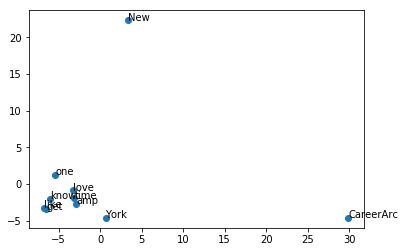

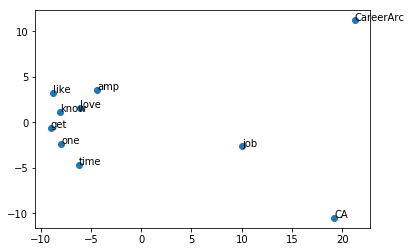

<Figure size 432x288 with 0 Axes>

In [7]:
src.plot_word_embeddings()
tgt.plot_word_embeddings()

In [8]:
print(src.vocab_size, tgt.vocab_size)

193899 95644


In [9]:
def load_data(src,
              src_translated,
              src_vocab,
              tgt_vocab,
              batch_size=32,
              max_seq_len=50,
              num_buckets=5):
  """Returns an iterator over the training data."""

  def _make_dataset(list_of_tweets, vocab):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.cast(list_of_tweets, dtype=tf.string)
    )
    dataset = dataset.map(lambda x: tf.string_split([x]).values) # Split on spaces.
    dataset = dataset.map(vocab.lookup)  
    return dataset

  def _key_func(x):
    bucket_width = (max_seq_len + num_buckets - 1) // num_buckets
    bucket_id = x["length"] // bucket_width
    bucket_id = tf.minimum(bucket_id, num_buckets)
    return tf.to_int64(bucket_id)

  def _reduce_func(unused_key, dataset):
    return dataset.padded_batch(batch_size, {
        "ids": [None],
        "ids_in": [None],
        "ids_out": [None],
        "length": [],
        "trans_ids": [None],
        "trans_length": []})

  bos = tf.constant([constants.START_OF_SENTENCE_ID], dtype=tf.int64)
  eos = tf.constant([constants.END_OF_SENTENCE_ID], dtype=tf.int64)

  # Make a dataset from the input and translated file.
  src_dataset = _make_dataset(src, src_vocab)
  tgt_dataset = _make_dataset(src_translated, tgt_vocab)
  dataset = tf.data.Dataset.zip((src_dataset, tgt_dataset))
  dataset = dataset.shuffle(200000)

  # Define the input format.
  dataset = dataset.map(lambda x, y: {
      "ids": x,
      "ids_in": tf.concat([bos, x], axis=0),
      "ids_out": tf.concat([x, eos], axis=0),
      "length": tf.shape(x)[0],
      "trans_ids": y,
      "trans_length": tf.shape(y)[0]})

  # Filter out invalid examples.
  dataset = dataset.filter(lambda x: tf.greater(x["length"], 0))

  # Batch the dataset using a bucketing strategy.
  dataset = dataset.apply(tf.contrib.data.group_by_window(
      _key_func,
      _reduce_func,
      window_size=batch_size))
  return dataset.make_initializable_iterator()

with tf.device("/cpu:0"):  # Input pipeline should always be place on the CPU.
  src_iterator = load_data(src.df.text, src.df.text, src.vocab, src.vocab)
  tgt_iterator = load_data(src.df.text, src.df.text, src.vocab, src.vocab)
  next_src = src_iterator.get_next()
  next_tgt = tgt_iterator.get_next()

In [10]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  sess.run([src_iterator.initializer, tgt_iterator.initializer])
  print(sess.run(next_src))

{'ids': array([[193898,      3, 193898,    320,    258, 193898,      0,      0,
             0],
       [ 17653, 193898,    164,   1614, 193898,    612, 193898,      0,
             0],
       [193898,     37, 193898, 193898, 193898,   1287,   1921,   1689,
           964],
       [  1153,  28654,  64824, 193898, 193898,   5445, 193898, 193898,
        193898],
       [  5943, 193898, 193898,      0,      0,      0,      0,      0,
             0],
       [  7298,   3952, 193898,      0,      0,      0,      0,      0,
             0],
       [  1852,     53,    125,   3677, 191649, 193898,      0,      0,
             0],
       [193898, 193898,    204, 193898,    966,    776, 193898, 193898,
             0],
       [193898,     82, 193898,   1573, 193898,    101, 193898,      9,
        193898],
       [193898,      9, 193898,    117, 193898, 193898, 193898,  13513,
        193898],
       [193898,   1040,     91, 193898, 193898,      0,      0,      0,
             0],
       [   70

In [14]:
def add_noise_python(words, dropout=0.1, k=3):
    """Applies the noise model in input words.

      Args:
        words: A numpy vector of word ids.
        dropout: The probability to drop words.
        k: Maximum distance of the permutation.

      Returns:
        A noisy numpy vector of word ids.
    """
    def _drop_words(words, probability):
        """Drops words with the given probability."""
        length = len(words)
        keep_prob = np.random.uniform(size=length)
        keep = np.random.uniform(size=length) > probability
        if np.count_nonzero(keep) == 0:
            ind = np.random.randint(0, length)
            keep[ind] = True
        words = np.take(words, keep.nonzero())[0]
        return words

    def _rand_perm_with_constraint(words, k):
        """Randomly permutes words ensuring that words are no more than k positions
        away from their original position."""
        length = len(words)
        offset = np.random.uniform(size=length) * (k + 1)
        new_pos = np.arange(length) + offset
        return np.take(words, np.argsort(new_pos))

    words = _drop_words(words, dropout)
    words = _rand_perm_with_constraint(words, k)
    return words

def add_noise(ids, sequence_length):
    """Wraps add_noise_python for a batch of tensors."""

    def _add_noise_single(ids, sequence_length):
        noisy_ids = add_noise_python(ids[:sequence_length])
        noisy_sequence_length = len(noisy_ids)
        ids[:noisy_sequence_length] = noisy_ids
        ids[noisy_sequence_length:] = 0
        return ids, np.int32(noisy_sequence_length)

    noisy_ids, noisy_sequence_length = tf.map_fn(
      lambda x: tf.py_func(_add_noise_single, x, [ids.dtype, tf.int32]),
      [ids, sequence_length],
      dtype=[ids.dtype, tf.int32],
      back_prop=False
    )

    noisy_ids.set_shape(ids.get_shape())
    noisy_sequence_length.set_shape(sequence_length.get_shape())

    return noisy_ids, noisy_sequence_length

In [16]:
from opennmt.inputters.text_inputter import load_pretrained_embeddings

def create_embeddings(vocab_size, depth=300):
    """Creates an embedding variable."""
    return tf.get_variable("embedding", shape=[vocab_size, depth])

def load_embeddings(embedding_file, vocab_file):
    """Loads an embedding variable or embeddings file."""
    try:
        embeddings = tf.get_variable("embedding")
    except ValueError:
        pretrained = load_pretrained_embeddings(
            embedding_file,
            vocab_file,
            num_oov_buckets=1,
            with_header=True,
            case_insensitive_embeddings=True)
        embeddings = tf.get_variable(
            "embedding",
            shape=None,
            trainable=False,
            initializer=tf.constant(pretrained.astype(np.float32)))
    return embeddings

In [17]:
src.vocab_size

193899

In [18]:
with tf.variable_scope("src"):
    src_emb = create_embeddings(str(src.vocab_size))

with tf.variable_scope("tgt"):
    tgt_emb = create_embeddings(str(src.vocab_size))

In [21]:
import opennmt as onmt
hidden_size = 512
encoder = onmt.encoders.BidirectionalRNNEncoder(2, hidden_size)

In [23]:
def add_noise_and_encode(ids, sequence_length, embedding, reuse=None):
    """Applies the noise model on ids, embeds and encodes.
      Args:
        ids: The tensor of words ids of shape [batch_size, max_time].
        sequence_length: The tensor of sequence length of shape [batch_size].
        embedding: The embedding variable.
        reuse: If True, reuse the encoder variables.
      Returns:
        A tuple (encoder output, encoder state, sequence length).
    """
    noisy_ids, noisy_sequence_length = add_noise(ids, sequence_length)
    noisy = tf.nn.embedding_lookup(embedding, noisy_ids)
    with tf.variable_scope("encoder", reuse=reuse):
        return encoder.encode(noisy, sequence_length=noisy_sequence_length)


In [24]:
src_encoder_auto = add_noise_and_encode(
    next_src["ids"], next_src["length"], src_emb, reuse=None)
tgt_encoder_auto = add_noise_and_encode(
    next_tgt["ids"], next_tgt["length"], tgt_emb, reuse=True)

src_encoder_cross = add_noise_and_encode(
    next_tgt["trans_ids"], next_tgt["trans_length"], src_emb, reuse=True)
tgt_encoder_cross = add_noise_and_encode(
    next_src["trans_ids"], next_src["trans_length"], tgt_emb, reuse=True)

Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead


In [25]:
decoder = onmt.decoders.AttentionalRNNDecoder(
    2, hidden_size, bridge=onmt.layers.CopyBridge())

In [29]:
from opennmt.utils.losses import cross_entropy_sequence_loss

def denoise(x, embedding, encoder_outputs, generator, reuse=None):
    """Denoises from the noisy encoding.
      Args:
        x: The input data from the dataset.
        embedding: The embedding variable.
        encoder_outputs: A tuple with the encoder outputs.
        generator: A tf.layers.Dense instance for projecting the logits.
        reuse: If True, reuse the decoder variables.
      Returns:
        The decoder loss.
    """
    with tf.variable_scope("decoder", reuse=reuse):
        logits, _, _ = decoder.decode(
            tf.nn.embedding_lookup(embedding, x["ids_in"]),
            x["length"] + 1,
            initial_state=encoder_outputs[1],
            output_layer=generator,
            memory=encoder_outputs[0],
            memory_sequence_length=encoder_outputs[2])
    cumulated_loss, _, normalizer = cross_entropy_sequence_loss(
      logits, x["ids_out"], x["length"] + 1)
    return cumulated_loss / normalizer

In [30]:
with tf.variable_scope("src"):
    src_gen = tf.layers.Dense(src.vocab_size)
    src_gen.build([None, hidden_size])

with tf.variable_scope("tgt"):
    tgt_gen = tf.layers.Dense(src.vocab_size)
    tgt_gen.build([None, hidden_size])

l_auto_src = denoise(next_src, src_emb, src_encoder_auto, src_gen, reuse=None)
l_auto_tgt = denoise(next_tgt, tgt_emb, tgt_encoder_auto, tgt_gen, reuse=True)

l_cd_src = denoise(next_src, src_emb, tgt_encoder_cross, src_gen, reuse=True)
l_cd_tgt = denoise(next_tgt, tgt_emb, src_encoder_cross, tgt_gen, reuse=True)

In [32]:
def binary_cross_entropy(x, y, smoothing=0, epsilon=1e-12):
    """Computes the averaged binary cross entropy.
      bce = y*log(x) + (1-y)*log(1-x)
      Args:
        x: The predicted labels.
        y: The true labels.
        smoothing: The label smoothing coefficient.
      Returns:
        The cross entropy.
    """
    y = tf.to_float(y)
    if smoothing > 0:
        smoothing *= 2
        y = y * (1 - smoothing) + 0.5 * smoothing
    return -tf.reduce_mean(tf.log(x + epsilon) * y + tf.log(1.0 - x + epsilon) * (1 - y))

def discriminator(encodings,
                  sequence_lengths,
                  lang_ids,
                  num_layers=3,
                  hidden_size=1024,
                  dropout=0.3):
    """Discriminates the encoder outputs against lang_ids.
      Args:
        encodings: The encoder outputs of shape [batch_size, max_time, hidden_size].
        sequence_lengths: The length of each sequence of shape [batch_size].
        lang_ids: The true lang id of each sequence of shape [batch_size].
        num_layers: The number of layers of the discriminator.
        hidden_size: The hidden size of the discriminator.
        dropout: The dropout to apply on each discriminator layer output.
      Returns:
        A tuple with: the discriminator loss (L_d) and the adversarial loss (L_adv).
    """
    x = encodings
    for _ in range(num_layers):
        x = tf.nn.dropout(x, 1.0 - dropout)
        x = tf.layers.dense(x, hidden_size, activation=tf.nn.leaky_relu)
    x = tf.nn.dropout(x, 1.0 - dropout)
    y = tf.layers.dense(x, 1)

    mask = tf.sequence_mask(
      sequence_lengths, maxlen=tf.shape(encodings)[1], dtype=tf.float32)
    mask = tf.expand_dims(mask, -1)

    y = tf.log_sigmoid(y) * mask
    y = tf.reduce_sum(y, axis=1)
    y = tf.exp(y)

    l_d = binary_cross_entropy(y, lang_ids, smoothing=0.1)
    l_adv = binary_cross_entropy(y, 1 - lang_ids)

    return l_d, l_adv

In [33]:
from opennmt.layers.reducer import pad_in_time

batch_size = tf.shape(next_src["length"])[0]
all_encoder_outputs = [
    src_encoder_auto, src_encoder_cross,
    tgt_encoder_auto, tgt_encoder_cross]
lang_ids = tf.concat([
    tf.fill([batch_size * 2], 0),
    tf.fill([batch_size * 2], 1)], 0)

max_time = tf.reduce_max([tf.shape(output[0])[1] for output in all_encoder_outputs])

encodings = tf.concat([
    pad_in_time(output[0], max_time - tf.shape(output[0])[1])
    for output in all_encoder_outputs], 0)
sequence_lengths = tf.concat([output[2] for output in all_encoder_outputs], 0)

with tf.variable_scope("discriminator"):
    l_d, l_adv = discriminator(encodings, sequence_lengths, lang_ids)

In [34]:
lambda_auto = 1
lambda_cd = 1
lambda_adv = 1

l_auto = l_auto_src + l_auto_tgt
l_cd = l_cd_src + l_cd_tgt

l_final = (lambda_auto * l_auto + lambda_cd * l_cd + lambda_adv * l_adv)

In [35]:
print(l_final)

Tensor("add_7:0", shape=(), dtype=float32)


In [36]:
def build_train_op(global_step, encdec_variables, discri_variables):
  """Returns the training Op.
  When global_step % 2 == 0, it minimizes l_final and updates encdec_variables.
  Otherwise, it minimizes l_d and updates discri_variables.
  Args:
    global_step: The training step.
    encdec_variables: The list of variables of the encoder/decoder model.
    discri_variables: The list of variables of the discriminator.
  Returns:
    The training op.
  """
  encdec_opt = tf.train.AdamOptimizer(learning_rate=0.0003, beta1=0.5)
  discri_opt = tf.train.RMSPropOptimizer(0.0005)
  encdec_gradients = encdec_opt.compute_gradients(l_final, var_list=encdec_variables)
  discri_gradients = discri_opt.compute_gradients(l_d, var_list=discri_variables)
  return tf.cond(
      tf.equal(tf.mod(global_step, 2), 0),
      true_fn=lambda: encdec_opt.apply_gradients(encdec_gradients, global_step=global_step),
      false_fn=lambda: discri_opt.apply_gradients(discri_gradients, global_step=global_step))

In [38]:
import sys

In [39]:
encdec_variables = []
discri_variables = []
for variable in tf.trainable_variables():
    if variable.name.startswith("discriminator"):
        discri_variables.append(variable)
    else:
        encdec_variables.append(variable)

global_step = tf.train.get_or_create_global_step()
train_op = build_train_op(global_step, encdec_variables, discri_variables)

i = 0
with tf.train.MonitoredTrainingSession(checkpoint_dir='/var/models/') as sess:
    sess.run([src_iterator.initializer, tgt_iterator.initializer])
    while not sess.should_stop():
        if i % 2 == 0:
            _, step, _l_auto, _l_cd, _l_adv, _l = sess.run(
                [train_op, global_step, l_auto, l_cd, l_adv, l_final])
            print("{} - l_auto = {}; l_cd = {}, l_adv = {}; l = {}".format(
                step, _l_auto, _l_cd, _l_adv, _l))
        else:
            _, step, _l_d = sess.run([train_op, global_step, l_d])
            print("{} - l_d = {}".format(step, _l_d))
        i += 1
        sys.stdout.flush()

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/models/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/models/model.ckpt.


FailedPreconditionError: Attempting to use uninitialized value src/embedding/Adam_3
	 [[Node: src/embedding/Adam_3/read = Identity[T=DT_FLOAT, _class=["loc:@cond_1/Adam/update_src/embedding/AssignSub"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](src/embedding/Adam_3)]]

Caused by op 'src/embedding/Adam_3/read', defined at:
  File "/home/divyagorantla/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/divyagorantla/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/divyagorantla/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/divyagorantla/anaconda3/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/divyagorantla/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-fcd38f543f29>", line 10, in <module>
    train_op = build_train_op(global_step, encdec_variables, discri_variables)
  File "<ipython-input-36-e6961bd823bd>", line 19, in build_train_op
    false_fn=lambda: discri_opt.apply_gradients(discri_gradients, global_step=global_step))
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2048, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1895, in BuildCondBranch
    original_result = fn()
  File "<ipython-input-36-e6961bd823bd>", line 18, in <lambda>
    true_fn=lambda: encdec_opt.apply_gradients(encdec_gradients, global_step=global_step),
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 588, in apply_gradients
    self._create_slots(var_list)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 135, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 1134, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1467, in get_variable
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1217, in get_variable
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 527, in get_variable
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 481, in _true_getter
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 903, in _get_single_variable
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2406, in default_variable_creator
    constraint=constraint)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 80, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3264, in identity
    "Identity", input=input, name=name)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/divyagorantla/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value src/embedding/Adam_3
	 [[Node: src/embedding/Adam_3/read = Identity[T=DT_FLOAT, _class=["loc:@cond_1/Adam/update_src/embedding/AssignSub"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](src/embedding/Adam_3)]]
